In [5]:
libraries = c("dplyr","magrittr","tidyr","ggplot2","RColorBrewer","zoo","lubridate","tidyverse",
              "readxl","gridExtra","MASS","ggpubr", "mixdist", "changepoint", "changepoint.np")
for(x in libraries) {library(x, character.only=TRUE, warn.conflicts=FALSE, quietly=TRUE)}

'%&%' = function(x,y)paste0(x,y)

theme_set(theme_bw())
version$version.string

options(scipen=10000)
Sys.setlocale("LC_ALL","Korean")

[1] "R version 4.3.2 (2023-10-31)"

Warning message in Sys.setlocale("LC_ALL", "Korean"):
“OS reports request to set locale to "Korean" cannot be honored”


[1] ""

# Settings

In [6]:
#### implementation time of major NPIs
NPI_0 <- as.Date("2021-11-01")
NPI_1 <- as.Date("2021-12-06") ## enhancing
NPI_2 <- as.Date("2022-02-19") ## relaxing (21 -> 22)
NPI_3 <- as.Date("2022-03-05") ## relaxing (22 -> 23)
NPI_4 <- as.Date("2022-04-04") ## relaxing (23 -> 24)
NPI_5 <- as.Date("2022-04-18") ## lifting all NPIs

#### population size by age group
popsize <- c(8514274, 13431836, 16792282, 12923898)

# Epidemic curve of COVID-19 in Korea

In [7]:
readRDS("master_df.rds") -> master_df
min_onset <- as.Date("2020-01-10")

master_df %<>% rename(sex=성별, region=거주시도, severity='위중증 유무(유:1)') %>%
mutate(diff = case_when(!is.na(onset) ~ as.numeric(as.Date(published) - as.Date(onset))))
master_df$diff[is.na(master_df$diff)] <- 0 
master_df %<>% mutate(onset = case_when(!is.na(onset) & onset < min_onset ~ as.Date(NA),
                                        !is.na(onset) & onset > max(master_df$published) ~ as.Date(NA),
                                        diff >= 30 ~ as.Date(NA),
                                        TRUE ~ onset)) %>% 
arrange(published) %>% dplyr::select(-c("diff", "severity")) %>%
mutate(sex = case_when(sex==c("여") ~ c("F"), TRUE ~ c("M")),
       route = case_when(route==c("국외") ~ c("Imported"), TRUE ~ c("Domestic")),
       variant = case_when(variant==c("-") ~ c("-"), variant==c("입실론형") ~ c("Epsilon"),
                           variant==c("알파형") ~ c("Alpha"), variant==c("베타형") ~ c("Beta"),
                           variant==c("제타형") ~ c("Zeta"), variant==c("감마형") ~ c("Gamma"),
                           variant==c("에타형") ~ c("Eta"), variant==c("이오타형") ~ c("Iota"),
                           variant==c("쎄타형") ~ c("Theta"), variant==c("카파형") ~ c("Kappa"),
                           variant==c("델타형") ~ c("Delta"), variant==c("뮤형") ~ c("Mu"),
                           variant==c("오미크론형") ~ c("Omicron"), variant==c("분석불가") ~ c("unknown"), TRUE ~ variant)) 

saveRDS(master_df, "master_df_Eng.rds")

In [8]:
as.numeric(max(master_df$published)-1-min(master_df$published)) -> time.diff
ttime <- as.data.frame(c(0:time.diff))
colnames(ttime) <- c('t')
ttime %<>% mutate(published = min(master_df$published)+t)

master_df %>% group_by(published) %>% count() %>% as.data.frame() -> data_fig
merge(ttime, data_fig, by='published', all.x=TRUE) -> master_df_figure
master_df_figure[is.na(master_df_figure)] <- 0

In [9]:
#### adding social distancing level (adjusted to the equivalent level as interventions in 2022)
master_df_figure %<>% 
mutate(level=case_when(published < as.Date("2020-06-28") ~ 2,
                       published >= as.Date("2020-06-28") & published < as.Date("2020-11-07") ~ 4,
                       published >= as.Date("2020-11-07") & published < as.Date("2021-03-05") ~ 3,
                       published >= as.Date("2021-03-05") & published < as.Date("2021-07-09") ~ 2,
                       published >= as.Date("2021-07-09") & published < as.Date("2021-11-01") ~ 4,
                       published >= as.Date("2021-11-01") & published < as.Date("2021-12-06") ~ 2,
                       published >= as.Date("2021-12-06") & published < as.Date("2022-02-19") ~ 4,
                       published >= as.Date("2022-02-19") & published < as.Date("2022-03-05") ~ 3,
                       published >= as.Date("2022-03-05") & published < as.Date("2022-04-04") ~ 2,
                       published >= as.Date("2022-04-04") & published < as.Date("2022-04-18") ~ 1,
                       published >= as.Date("2022-04-18") ~ 0))

[1] 18397436

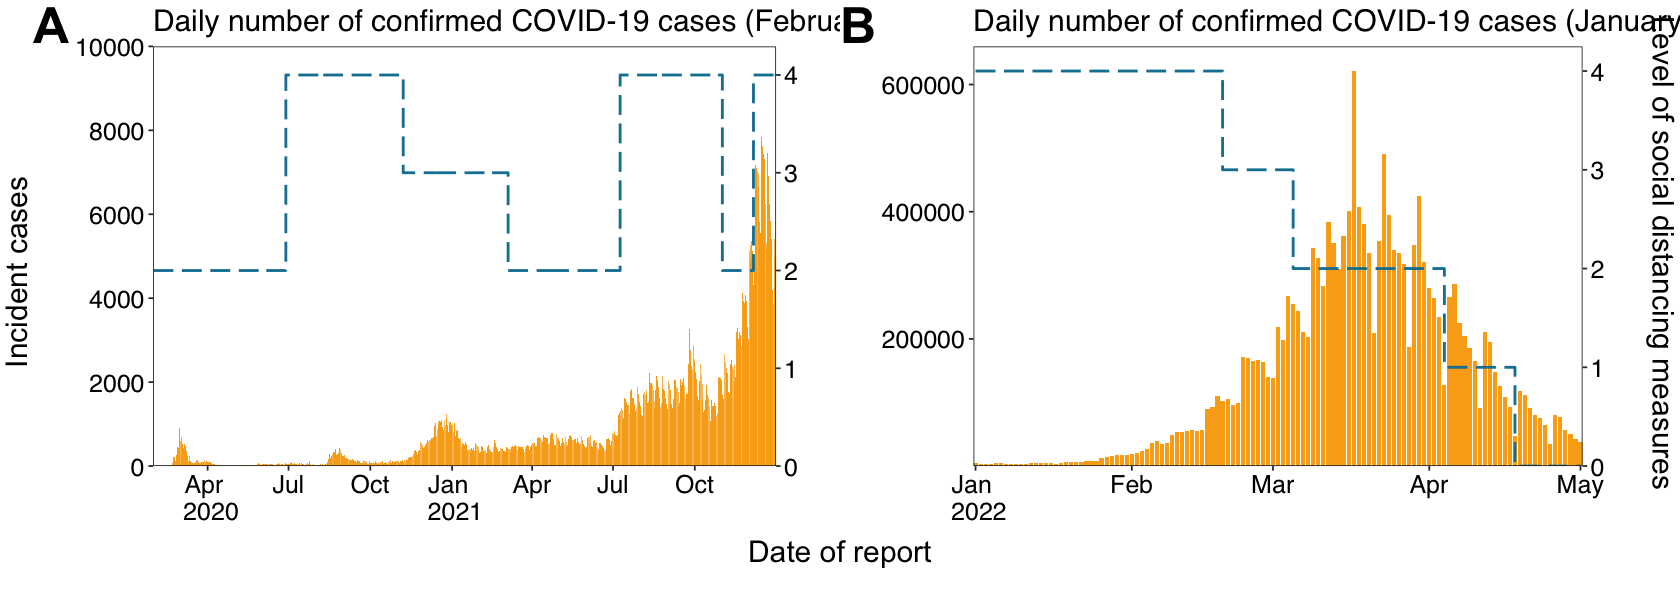

In [10]:
scaling_parameter=max(master_df_figure$n)/max(master_df_figure$level)
adj=0.015

options(repr.plot.width=7,repr.plot.height=5, warn=-1)
master_df_figure %>% filter(published >= as.Date("2020-01-31") & published < as.Date("2022-01-01")) %>%
    ggplot() + 
    geom_bar(aes(x=published, y=n), fill="#FAAB18", stat='identity', width=0.83) +
    geom_step(aes(x=published,y=level*scaling_parameter*adj),color="#1380A1",linetype='longdash',size=0.8) +
    ggtitle("Daily number of confirmed COVID-19 cases (February 2020 - December 2021)") +
    labs(x="\n Date of reporting", y="Incidence \n") +
    labs(x="", y="") +
    scale_x_date(date_breaks = "3 months", expand = c(0, 0),
                 labels = function(x) if_else(is.na(lag(x)) | !year(lag(x)) == year(x), 
                                              paste(month(x, label = TRUE), "\n", year(x)), 
                                              paste(month(x, label = TRUE)))) +
    scale_y_continuous(expand = c(0, 0), breaks=c(0,2000,4000,6000,8000,10000),
                       sec.axis = sec_axis(~./(scaling_parameter*adj), breaks=c(0,1,2,3,4), name = "")) +
    theme(text = element_text(size=15, family="sans",color="black"),
          axis.title = element_text(size=18, family="sans",color="black"),
          axis.text = element_text(size=15, family="sans",color="black"),
          panel.grid.major = element_blank(), panel.grid.minor = element_blank(),
          legend.title = element_text(size = 15),
          legend.text = element_text(size = 15)) +
    coord_cartesian(ylim = c(0,10000)) -> Fig_2021

                 
options(repr.plot.width=7,repr.plot.height=5, warn=-1)

adj2=1.0      
master_df_figure %>% filter(published >= as.Date("2022-01-01") & published <= as.Date("2022-05-01")) %>%
    ggplot() + 
    geom_bar(aes(x=published, y=n), fill="#FAAB18", stat='identity', width=0.83) +
    geom_step(aes(x=published,y=level*scaling_parameter*adj2),color="#1380A1",linetype='longdash',size=0.8) +
    ggtitle("Daily number of confirmed COVID-19 cases (January 2022 - April 2022)") +
    labs(x="\n Date of reporting", y="Incidence \n") +
    labs(x="", y="") +
    scale_x_date(date_breaks = "1 months", expand = c(0, 0),
                 labels = function(x) if_else(is.na(lag(x)) | !year(lag(x)) == year(x), 
                                              paste(month(x, label = TRUE), "\n", year(x)), 
                                              paste(month(x, label = TRUE)))) +
    scale_y_continuous(expand = c(0, 0), breaks=c(200000,400000,600000),
                       sec.axis = sec_axis(~./(scaling_parameter*adj2), breaks=c(0,1,2,3,4), name = "")) +
    theme(text = element_text(size=15, family="sans",color="black"),
          axis.title = element_text(size=18, family="sans",color="black"),
          axis.text = element_text(size=15, family="sans",color="black"),
          panel.grid.major = element_blank(), panel.grid.minor = element_blank(),
          legend.title = element_text(size = 15),
          legend.text = element_text(size = 15)) +
    coord_cartesian(ylim = c(0,660000)) -> Fig_2022
                 
sum(master_df_figure$n)

options(repr.plot.width=14,repr.plot.height=5)
ggarrange(Fig_2021, Fig_2022, ncol = 2, nrow = 1, 
          labels = c("A", "B"), vjust=1.2, hjust=0, font.label = list(size = 30)) -> Fig_case

annotate_figure(Fig_case, 
                left=text_grob("Incident cases", size=18, rot=90, hjust=0.35),
                right=text_grob("Level of social distancing measures", size=18, rot=270, hjust=0.6),
                bottom=text_grob("Date of report", size=18, vjust=-1)) -> Fig_case_combined

Fig_case_combined

# Time delay from the symptom onset to report

In [11]:
upper_delay = 13

readRDS("delay_stepp.rds") -> delay_stepp
readRDS("temp_stepp.rds") -> temp_stepp
readRDS("delay_figure.rds") -> delay_figure
readRDS("delay_stepp_org.rds") -> delay_stepp_org
readRDS("fit_changepoint.rds") -> fit_changepoint
readRDS("tstar.rds") -> tstar
readRDS("datestar.rds") -> datestar

[1] "2020-05-01" "2021-06-01" "2022-03-01"

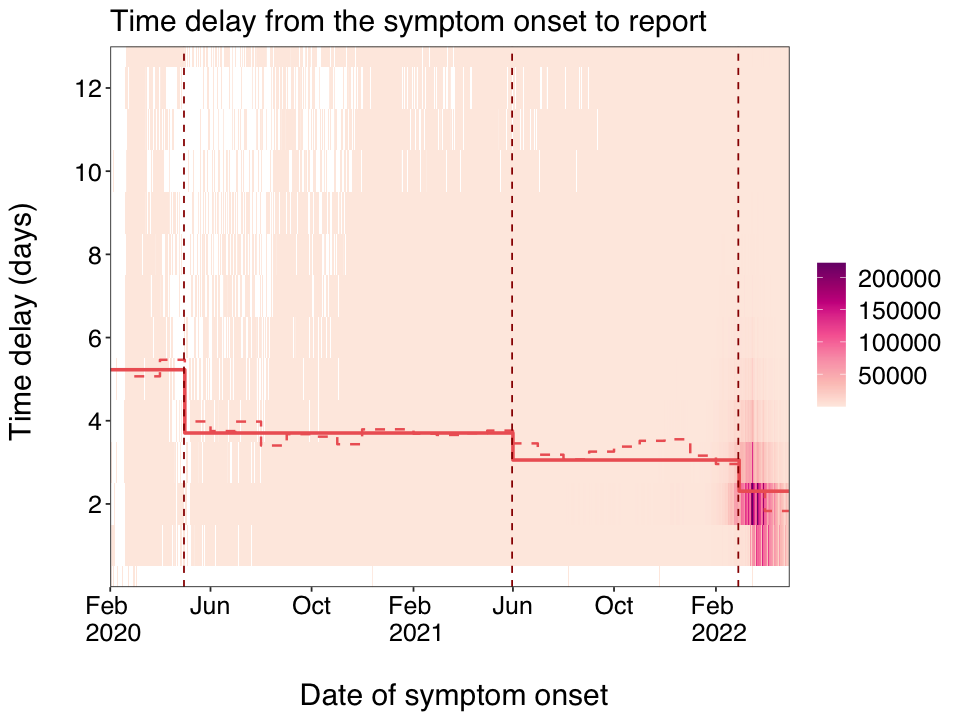

In [12]:
options(repr.plot.width=8,repr.plot.height=6, warn=-1)
delay_figure %>% filter(n>0) %>%
ggplot(aes(x=date, y=d)) + 
geom_tile(aes(fill=n)) +
scale_fill_distiller("", palette = "RdPu", direction=1) +
coord_cartesian(expand=F, ylim=c(0, upper_delay)) +
geom_step(data=delay_stepp, aes(x=delay_month, y=mu), color="indianred2", size=1) +
geom_step(data=delay_stepp_org, aes(x=delay_month, y=mu), color="indianred2", size=0.7,linetype="dashed") +
labs(x='\n Time of reporting', y='Time delay (days) \n') +
labs(x='\n Date of symptom onset', y='Time delay (days) \n') +
ggtitle("Time delay from the symptom onset to report") +
theme(text = element_text(size=15, family="sans",color="black"),
      axis.title = element_text(size=18, family="sans",color="black"),
      axis.text = element_text(size=15, family="sans",color="black"),
      panel.grid.major = element_blank(), panel.grid.minor = element_blank(),
      legend.title = element_text(size = 15),
      legend.text = element_text(size = 15)) +

geom_vline(xintercept = temp_stepp$date[cpts(fit_changepoint)[1]], linetype="dashed", color = "#990000", size=0.5) +
geom_vline(xintercept = temp_stepp$date[cpts(fit_changepoint)[2]], linetype="dashed", color = "#990000", size=0.5) +
geom_vline(xintercept = temp_stepp$date[cpts(fit_changepoint)[3]], linetype="dashed", color = "#990000", size=0.5) +

scale_x_date(date_breaks="4 months", limits=c(as.Date("2020-02-01"), as.Date("2022-05-01")),
             labels = function(x) if_else(is.na(lag(x)) | !year(lag(x)) == year(x), 
                                          paste(month(x, label = TRUE), "\n", year(x)), 
                                          paste(month(x, label = TRUE)))) +
scale_y_continuous(expand = c(0, 0), breaks=c(2, 4, 6, 8, 10, 12)) -> Fig_delay

Fig_delay
             
c(temp_stepp$date[cpts(fit_changepoint)[1]]+1, temp_stepp$date[cpts(fit_changepoint)[2]]+1, 
  temp_stepp$date[cpts(fit_changepoint)[3]]+1)

In [13]:
(delay_stepp[1:4,] %>% mutate(distribution=c("Weibull")) %>% 
 rename(delay_date = delay_month, mean=mu, SD = sigma) %>%
 dplyr::select(delay_date, mean, SD, shape, scale, distribution) -> delay_est)
saveRDS(delay_est, "dealy_est.rds")

,delay_date,mean,SD,shape,scale,distribution
,<date>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>
1,2020-02-01,5.226586,3.464071,1.539863,5.807141,Weibull
2,2020-05-01,3.705257,2.506217,1.506196,4.106467,Weibull
3,2021-06-01,3.055951,1.660344,1.916046,3.444748,Weibull
4,2022-03-01,2.306791,1.196031,2.018186,2.603338,Weibull


# Variant proportion

In [14]:
# master_df %>% filter(published >= as.Date("2020-02-01") & published <= as.Date("2022-07-09")) %>%
# mutate(Year=MMWRweek::MMWRweek(published)$MMWRyear,
#                      Week=MMWRweek::MMWRweek(published)$MMWRweek, date=paste0(Year, Week)) %>%
# dplyr::select(variant, date) %>% #filter(!(variant %in% c("NA", "unknown"))) %>%
# mutate(varaint_group=case_when(variant==c("-") ~ c("Original"), 
#                                is.na(variant) ~ c("None"), variant==c("NA") ~ c("None"), 
#                                variant==c("unknown") ~ c("None"), 
#                                variant %in% c("Zeta", "Epsilon", "Beta", "Eta", "Gamma", "Theta",
#                                               "Iota", "Kappa", "Mu") ~ c("Etc"), TRUE ~ variant)) -> temp
# saveRDS(temp, "master_prop_temp.rds")

In [15]:
# readRDS("master_prop_temp.rds") -> master_prop

# temp %>% group_by(date, varaint_group) %>% summarise(n = n()) %>% mutate(freq = 1-(n / sum(n))) %>% 
# filter(varaint_group==c("None")) %>% filter(str_detect(date, "^2021")) -> temp2 ; unique(temp2$freq)

In [16]:
# master_df %>% filter(published >= as.Date("2020-02-01") & published <= as.Date("2022-07-09")) %>%
# mutate(Year=MMWRweek::MMWRweek(published)$MMWRyear,
#                      Week=MMWRweek::MMWRweek(published)$MMWRweek, date=paste0(Year, Week)) %>%
# dplyr::select(variant, date) %>% filter(!(variant %in% c("NA", "unknown"))) %>%
# mutate(varaint_group=case_when(variant==c("-") ~ c("Original"), 
#                                variant %in% c("Zeta", "Epsilon", "Beta", "Eta", "Gamma", "Theta",
#                                               "Iota", "Kappa", "Mu") ~ c("Etc"), TRUE ~ variant)) %>% 
# filter(varaint_group %in% c("Original", "Alpha", "Delta", "Omicron", "Etc")) %>%
# dplyr::select(-variant) %>% rename(variant=varaint_group) -> master_prop

# saveRDS(master_prop, "master_prop.rds")

In [17]:
readRDS("master_prop.rds") -> master_prop
master_prop %<>% mutate(date_new=case_when(nchar(date)==5 ~ paste0(substr(date, 1, 4),"0",substr(date, 5, 6)),
                                           TRUE~date)) %>% dplyr::select(-date) %>% rename(date=date_new)
unique(master_prop$variant)

[1] "Original" "Etc"      "Alpha"    "Delta"    "Omicron"

In [18]:
as.data.frame(unique(master_prop$date)) -> prop_cal; colnames(prop_cal) <- c("date")

master_prop %>% count(variant, date) %>% arrange(date) -> master_group
unique(master_group$date) %>% as.data.frame() -> group_cal
colnames(group_cal) <- c("date")

master_group %<>% spread(date, n) %>% t() %>% as.data.frame()
colnames(master_group) <- master_group[1,]
master_group[-1,] -> master_group

cbind(master_group, group_cal) -> master_group
merge(master_group, prop_cal, by=c("date"), all.y=TRUE) -> master_group 
master_group[is.na(master_group)] <- 0

as.integer(master_group$Omicron) -> master_group$Omicron; as.integer(master_group$Delta) -> master_group$Delta
as.integer(master_group$Alpha) -> master_group$Alpha; as.integer(master_group$Etc) -> master_group$Etc
as.integer(master_group$Original) -> master_group$Original

master_group %>% mutate(Omicron_prop = Omicron/(Omicron+Delta+Alpha+Etc+Original), 
                        Delta_prop = Delta/(Omicron+Delta+Alpha+Etc+Original),
                        Alpha_prop = Alpha/(Omicron+Delta+Alpha+Etc+Original),
                        Etc_prop = Etc/(Omicron+Delta+Alpha+Etc+Original),
                        Original_prop = Original/(Omicron+Delta+Alpha+Etc+Original)) %>%
dplyr::select(date, Omicron_prop, Delta_prop, Alpha_prop, Etc_prop, Original_prop) %>%
rename(Omicron=Omicron_prop, Delta=Delta_prop, Alpha=Alpha_prop, Etc=Etc_prop, Original=Original_prop) -> prop_df

In [22]:
prop_df %>% gather(date, group) -> prop_fig
cbind(prop_fig, master_group$date) -> prop_fig
colnames(prop_fig) <- c("group", "prop", "date")
prop_fig %<>% mutate(year=as.numeric(substr(date, 1, 4)), week=as.numeric(substr(date, 5, 6)),
                    Date=MMWRweek::MMWRweek2Date(year, week, 1)) %>%
mutate(group=case_when(group=="Etc" ~ c("Etc."), group=="Original" ~ c("Wild-type"), TRUE~group))

prop_fig$group <- factor(prop_fig$group, levels=c('Wild-type','Alpha','Etc.','Delta','Omicron'))

In [23]:
as.data.frame(c('Wild-type','Alpha','Etc.','Delta','Omicron')) %>% 
mutate(prop=0,date=c("202211"), year=2022, week=11, Date=as.Date("2022-03-13")) -> temp
colnames(temp) <- c("group", "prop", "date", "year", "week", "Date")
temp %<>% mutate(prop=case_when(group==c("Omicron")~1, TRUE~prop))

rbind(prop_fig, temp) -> prop_fig

saveRDS(prop_fig, "prop.rds")

In [24]:
prop_fig %>% filter(group==c("Delta")) %>% filter(Date >= as.Date("2021-08-08")) %>% head(3)
# prop_fig %>% filter(group==c("Omicron")) %>% filter(abs(prop - 0.9) == min(abs(prop - 0.9)))
# prop_fig %>% filter(group==c("Omicron")) %>% filter(abs(prop - 0.1) == min(abs(prop - 0.1)))

,group,prop,date,year,week,Date
,<fct>,<dbl>,<chr>,<dbl>,<dbl>,<date>
1,Delta,0.9362245,202132,2021,32,2021-08-08
2,Delta,0.9564669,202133,2021,33,2021-08-15
3,Delta,0.9775745,202134,2021,34,2021-08-22


In [31]:
prop_fig %>% filter(group==c("Omicron")) %>% filter(abs(prop - 0.9) == min(abs(prop - 0.9)))
prop_fig %>% filter(group==c("Omicron")) %>% filter(abs(prop - 0.1) == min(abs(prop - 0.1)))

group,prop,date,year,week,Date
<fct>,<dbl>,<chr>,<dbl>,<dbl>,<date>
Omicron,0.8546044,202203,2022,3,2022-01-16


group,prop,date,year,week,Date
<fct>,<dbl>,<chr>,<dbl>,<dbl>,<date>
Omicron,0.07954545,202151,2021,51,2021-12-19


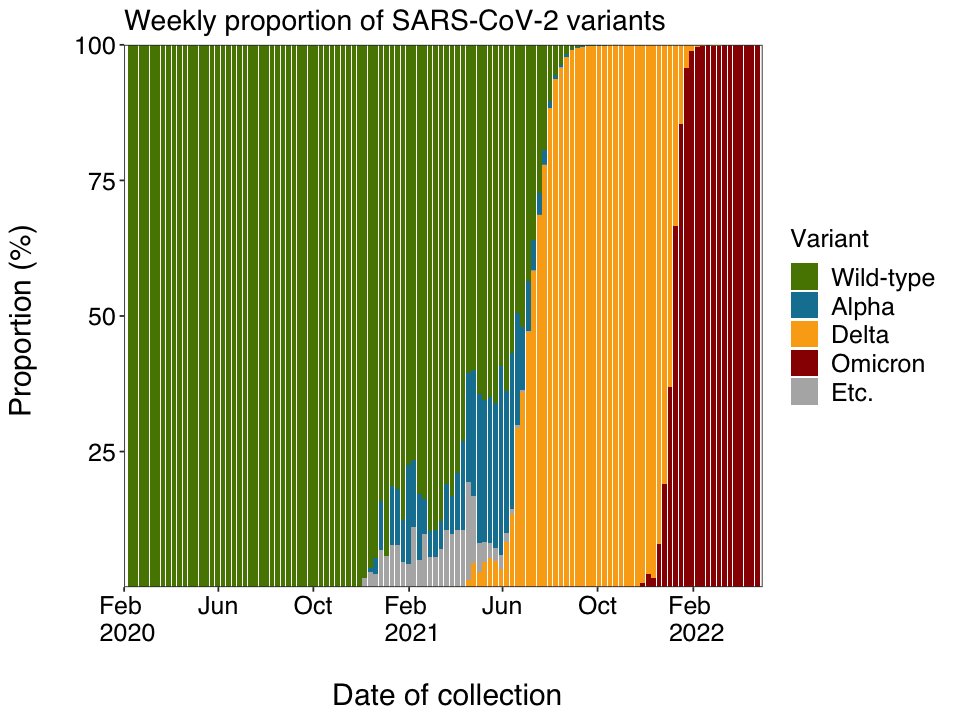

In [25]:
options(repr.plot.width=8,repr.plot.height=6)

prop_fig %>% filter(Date >= as.Date("2020-02-02") & Date <= as.Date("2022-05-01")) %>%
    ggplot() + 
    geom_bar(aes(x=Date, y=prop*100, fill=group), stat='identity', width=6) +
    scale_fill_manual("Variant",
                      values=c('Wild-type'='#588300','Alpha'='#1380A1','Etc.'='grey70',
                               'Delta'="#FAAB18", 'Omicron'="#990000"),
                      breaks=c('Wild-type','Alpha','Delta','Omicron',"Etc.")) +
    ggtitle("Weekly proportion of SARS-CoV-2 variants") +
    labs(x="\n Date of collection", y="Proportion (%) \n") +
    theme(text = element_text(size=15, family="sans",color="black"),
          axis.title = element_text(size=18, family="sans",color="black"),
          axis.text = element_text(size=15, family="sans",color="black"),
          panel.grid.major = element_blank(), panel.grid.minor = element_blank(),
          legend.title = element_text(size = 15),
          legend.text = element_text(size = 15),
          plot.title = element_text(size=17, family="sans",color="black")) +
    scale_y_continuous(expand = c(0, 0), breaks=c(25, 50, 75, 100)) +
    scale_x_date(expand = c(0, 0), date_breaks="4 months", limits=c(as.Date("2020-02-01"), as.Date("2022-05-01")),
                 labels = function(x) if_else(is.na(lag(x)) | !year(lag(x)) == year(x), 
                                              paste(month(x, label = TRUE), "\n", year(x)), 
                                              paste(month(x, label = TRUE)))) +
    coord_cartesian(ylim = c(0,100)) -> Fig_variant
           
Fig_variant

# Vaccination coverage

In [26]:
## vax data
read_excel("../../G-ABC_COVID_forecasting/data/vaxx_0307_long.xlsx") -> vax_df

vax_df$date <- as.Date(vax_df$date)

vax_df %<>% rename(order=차수, age=연령, 
                   Pfizer=pf, JJ=j, Moderna=m, AZ=az, Nova=nvx) %>%
mutate(age_group = case_when(age %in% c("17세이하", "18-19세") ~ "1",
                             age %in% c("20-29세", "30-39세") ~ "2",
                             age %in% c("40-49세", "50-59세") ~ "3",
                             age %in% c("60-64세", "65-69세", "70-74세", "75-79세", "80세이상") ~ "4")) %>%
mutate(week = strftime(date, "%V")) %>% mutate(mRNA = Pfizer + Moderna, Cross = Nova + etc) %>%
dplyr::select(c("date", "mRNA", "JJ", "AZ", "Cross", "week", "order", "age_group")) %>%
filter(date < as.Date("2022-01-08"))

vax_df[is.na(vax_df)] <- 0

vax_df$week <- as.integer(vax_df$week)

read_excel("../../G-ABC_COVID_forecasting/data/vac_0709.xlsx") %>% mutate(mRNA = P + M, Cross = N + E) %>% 
rename(week=WEEK, JJ=J, order=VCNTME) %>%
mutate(age_group = case_when(AGE %in% c(8, 9) ~ "1",
                             AGE %in% c(6, 7) ~ "2",
                             AGE %in% c(4, 5) ~ "3",
                             AGE %in% c(1, 2, 3) ~ "4"))-> vax_df2

vax_df2 %<>% rowwise()%>% mutate(date = MMWRweek::MMWRweek2Date(2022,(week-1),7)) %>%
dplyr::select(date, mRNA, JJ, AZ, Cross, week, order, age_group)
rbind(vax_df, vax_df2) %>% dplyr::select(date, order, age_group, mRNA, JJ, AZ, Cross) -> vax_df

saveRDS(vax_df, "vax_df.rds")

In [27]:
vax_df %>% mutate(sum_vac=mRNA+JJ+AZ+Cross) %>% group_by(date, order, age_group) %>% 
mutate(allsum_vac = cumsum(sum_vac)) %>% group_by(date, order, age_group) %>% 
summarize(maxsum_vac = max(allsum_vac)) %>% ungroup %>%
group_by(order) %>% mutate(cum_vac=cumsum(maxsum_vac)) %>% ungroup %>%
group_by(date, order) %>% summarize(final_vac = max(cum_vac)/sum(popsize)) %>% filter(order<=3) %>% 
mutate(dose=case_when(order==1 ~ c("1st dose"), order==2 ~ ("2nd dose"), order==3 ~ ("1st booster"))) %>%
mutate(final_vac_per=final_vac*100) -> df_vaccov

`summarise()` has grouped output by 'date', 'order'. You can override using the
`.groups` argument.
`summarise()` has grouped output by 'date'. You can override using the
`.groups` argument.


In [28]:
rep(seq(as.Date("2021-02-01"), as.Date("2021-03-05"), by=1), 3) %>% as.data.frame() %>% 
mutate(order=rep(c(1,2,3), each=length(seq(as.Date("2021-02-01"), as.Date("2021-03-05"), by=1))),
       dose=rep(c("1st dose", "2nd dose", "1st booster"), each=length(seq(as.Date("2021-02-01"), as.Date("2021-03-05"), by=1))),
       final_vac=0, final_vac_per=0) %>% rename(date='.') -> temp

rbind(df_vaccov, temp) -> df_vaccov

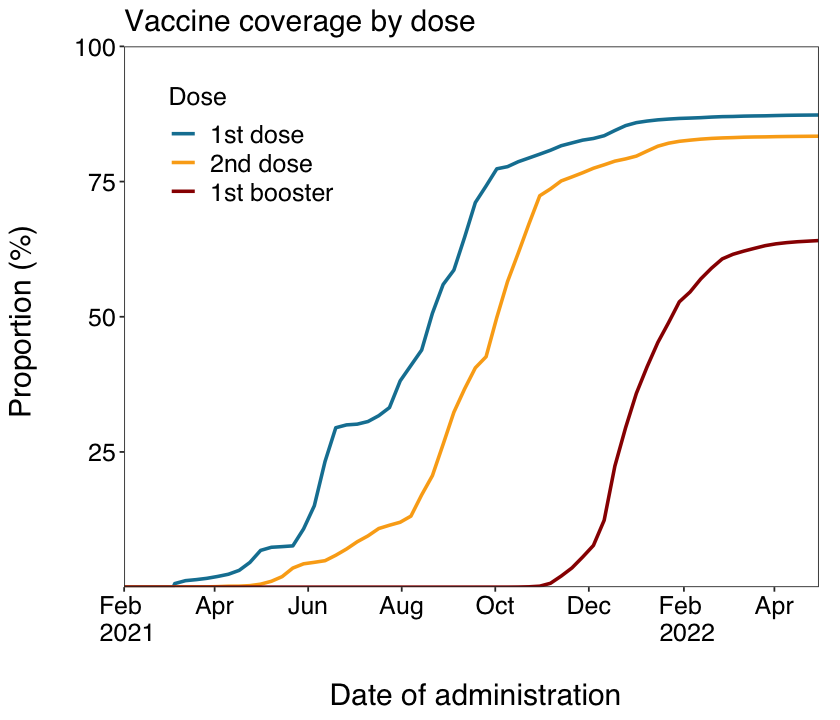

In [29]:
# df_vaccov %>% filter(order==2) %>% mutate(t = as.numeric(date - as.Date("2021-03-06"))/7) -> df_vaccov_2
# df_vaccov %>% filter(order==3) %>% mutate(t = as.numeric(date - as.Date("2021-03-06"))/7) -> df_vaccov_3

df_vaccov$dose <- factor(df_vaccov$dose, levels=c('1st dose','2nd dose','1st booster'))

options(repr.plot.width=7,repr.plot.height=6)
ggplot() + 
geom_line(data=df_vaccov %>% filter(date <= as.Date("2022-05-01")), 
          aes(x=date, y=final_vac_per, group=dose, colour=dose), size=1) +
scale_colour_manual("Dose",  values = c("1st dose"="#1380A1", "2nd dose"="#FAAB18", "1st booster"="#990000")) +
ggtitle("Vaccine coverage by dose") +
labs(x="\n Date of administration", y="Proportion (%) \n") +
theme(text = element_text(size=15, family="sans",color="black"),
      axis.title = element_text(size=18, family="sans",color="black"),
      axis.text = element_text(size=15, family="sans",color="black"),
      panel.grid.major = element_blank(), panel.grid.minor = element_blank(),
      legend.title = element_text(size = 15),
      legend.text = element_text(size = 15),
      plot.title = element_text(size=18, family="sans",color="black"),
      legend.position = c(.05, .95),
      legend.justification = c("left", "top"), legend.box.just = "left", legend.margin = margin(6, 6, 6, 6)) +
scale_y_continuous(expand = c(0, 0), breaks=c(25, 50, 75, 100)) +
coord_cartesian(ylim = c(0,100)) +
 scale_x_date(date_breaks = "2 months", expand = c(0, 0),
              labels = function(x) if_else(is.na(lag(x)) | !year(lag(x)) == year(x), 
                                           paste(month(x, label = TRUE), "\n", year(x)), 
                                           paste(month(x, label = TRUE)))) -> Fig_vaccov
              
annotate_figure(Fig_vaccov, right=text_grob("", size=16)) -> Fig_vaccov
Fig_vaccov

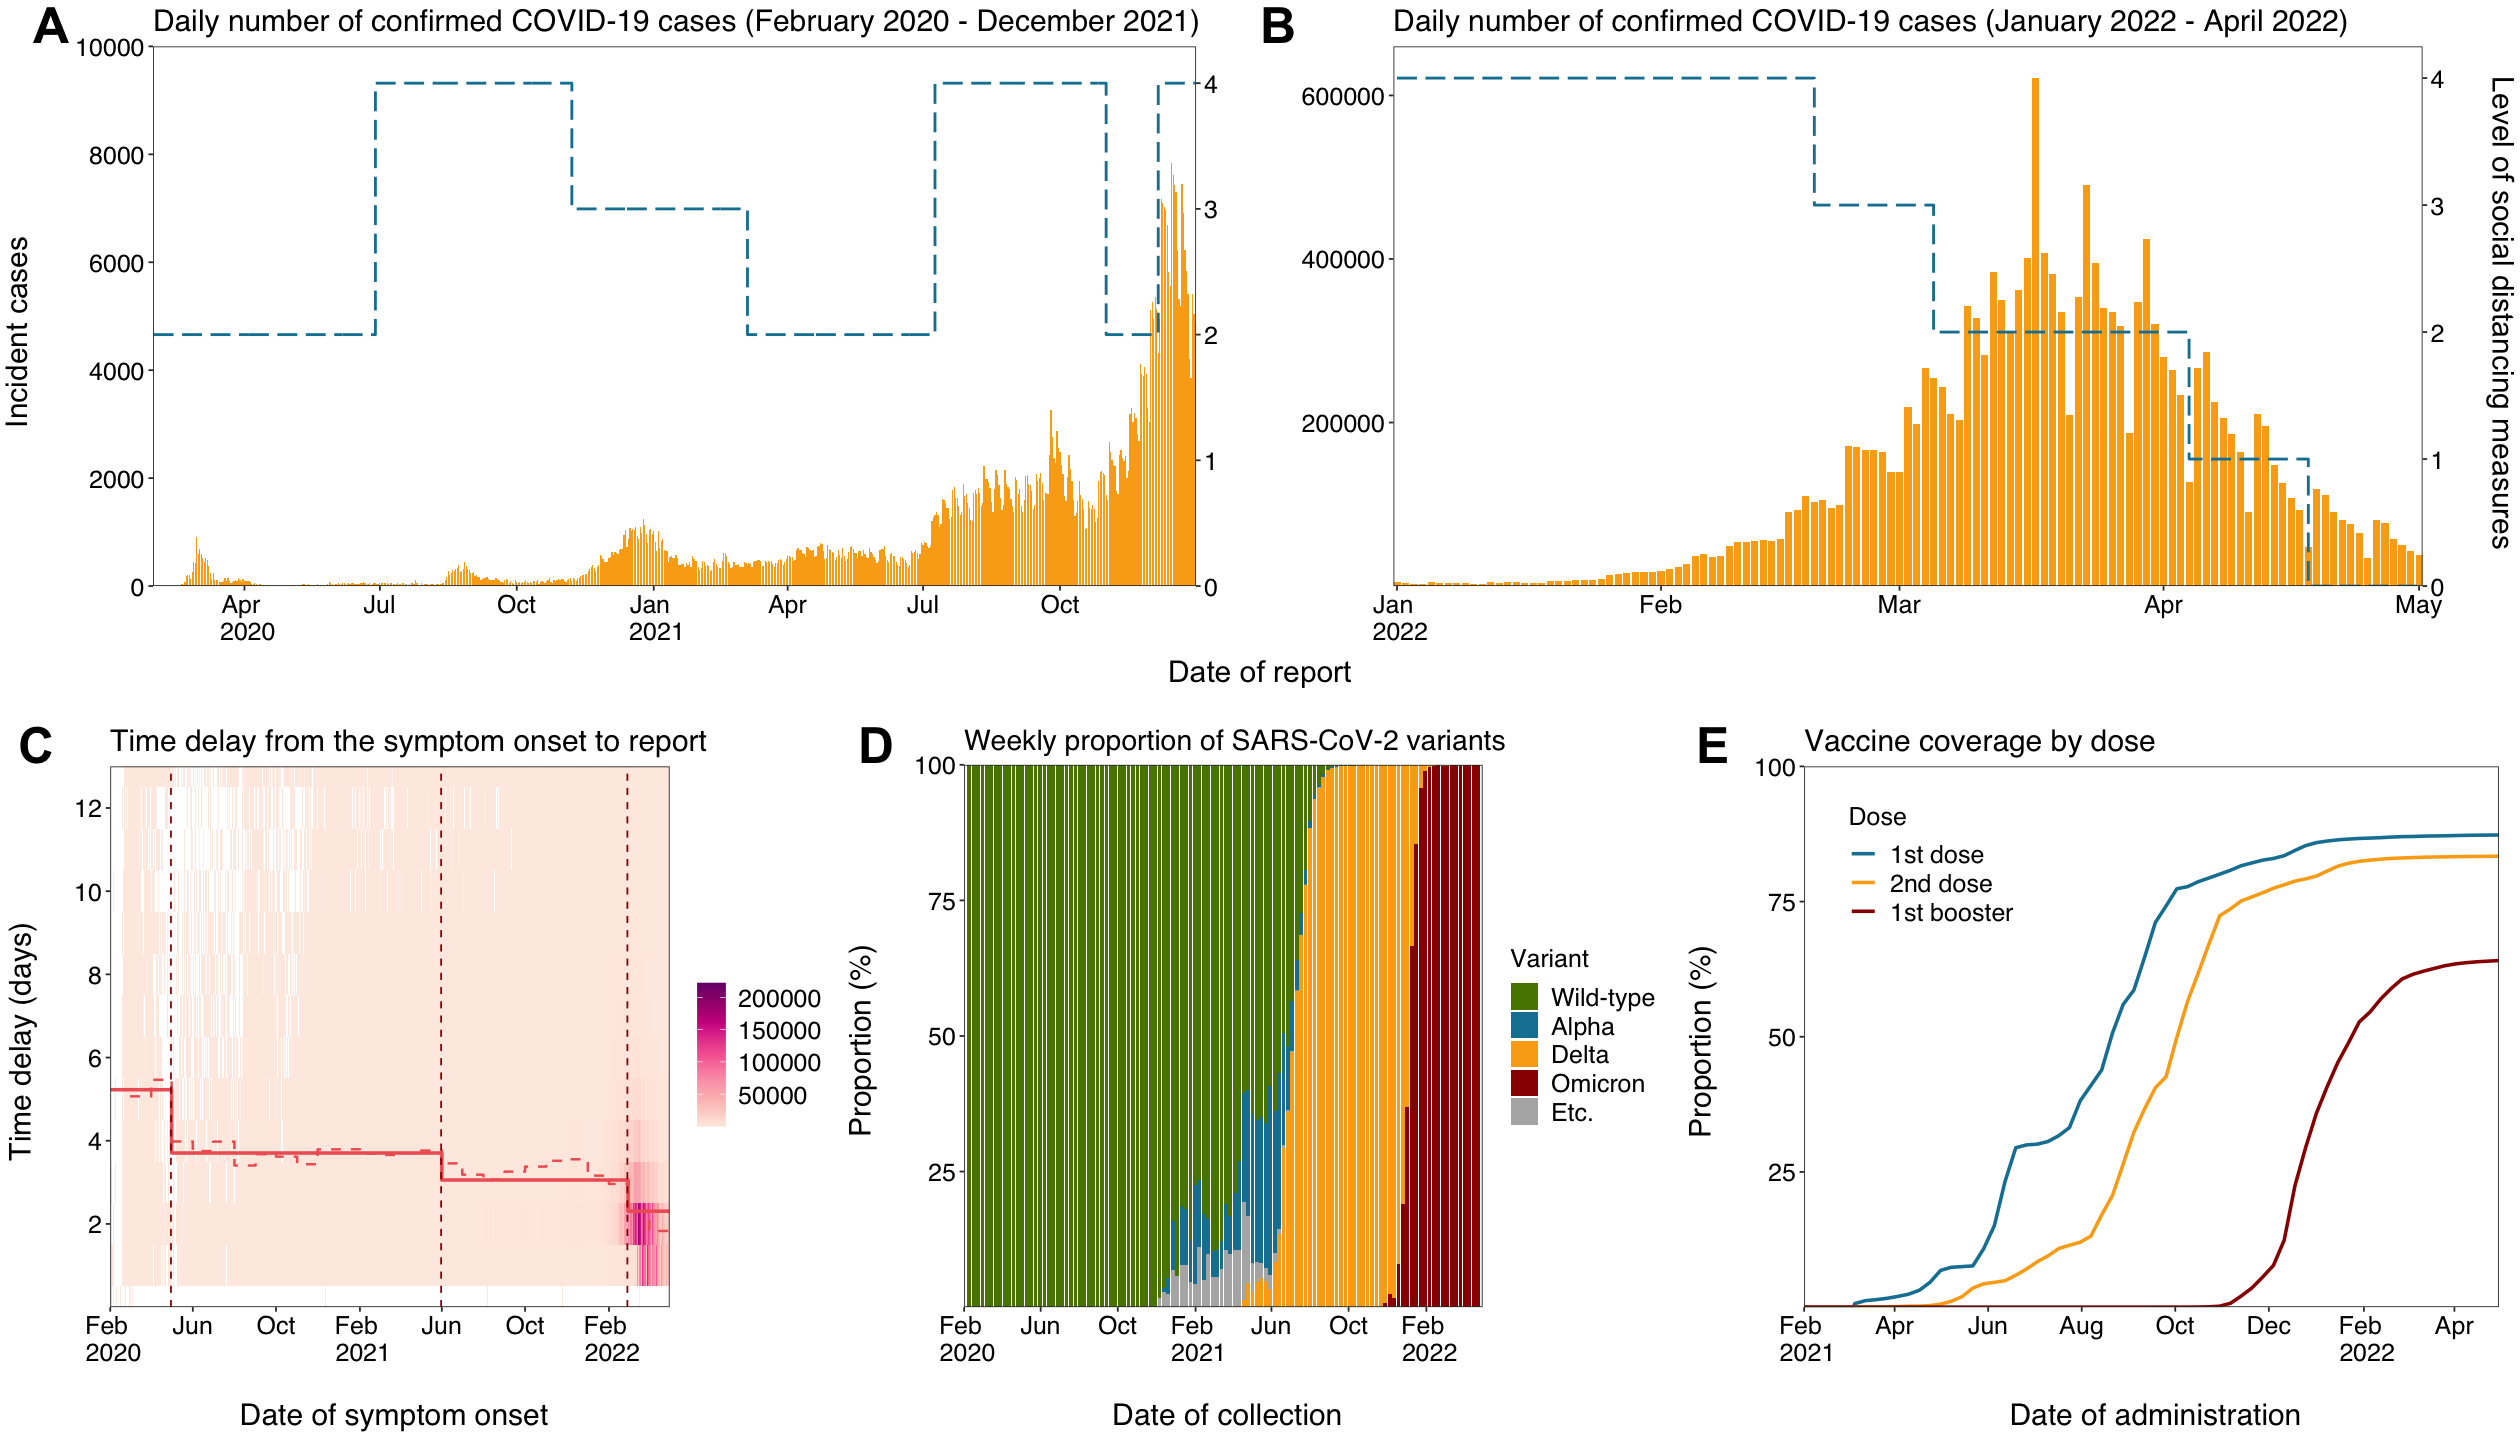

In [30]:
options(repr.plot.width=21,repr.plot.height=6)
ggarrange(Fig_delay, Fig_variant, Fig_vaccov, ncol = 3, nrow = 1, align = "v",
          labels = c("C", "D", "E"), vjust=1.2, font.label = list(size = 30)) -> Fig1_2

options(repr.plot.width=21,repr.plot.height=12)
ggarrange(Fig_case_combined, Fig1_2, ncol = 1, nrow = 2)

ggsave("../figures/Final figures/Fig_1.png", width = 21, height = 12, dpi=300, bg="white")